In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Task 1: Load Two Data Sets and print them using df.head() separately.
df_1 = pd.read_csv('DF_1_FAOSTAT_data_en_11-19-2025.csv')
df_2 = pd.read_csv('DF_2_Crop_recommendation.csv')

print("--- Yield Dataset (DF_1) ---")
print(df_1.head())
print("\n--- Crop Recommendation Dataset (DF_2) ---")
print(df_2.head())

--- Yield Dataset (DF_1) ---
  Domain Code                        Domain  Area Code (M49)   Area  \
0         QCL  Crops and livestock products              356  India   
1         QCL  Crops and livestock products              356  India   
2         QCL  Crops and livestock products              356  India   
3         QCL  Crops and livestock products              356  India   
4         QCL  Crops and livestock products              356  India   

   Element Code         Element  Item Code (CPC)  \
0          5312  Area harvested           1654.0   
1          5412           Yield           1654.0   
2          5510      Production           1654.0   
3          5312  Area harvested           1654.0   
4          5412           Yield           1654.0   

                                                Item  Year Code  Year   Unit  \
0  Anise, badian, coriander, cumin, caraway, fenn...       2000  2000     ha   
1  Anise, badian, coriander, cumin, caraway, fenn...       2000  2000  

In [2]:
# Task 2: Filter Yield Dataset for Area = India only, print it using df.head() and df.shape().
df_1_india = df_1[df_1['Area'] == 'India'].copy()

print("Filtered Dataset Head:")
print(df_1_india.head())
print("\nFiltered Dataset Shape:", df_1_india.shape)

Filtered Dataset Head:
  Domain Code                        Domain  Area Code (M49)   Area  \
0         QCL  Crops and livestock products              356  India   
1         QCL  Crops and livestock products              356  India   
2         QCL  Crops and livestock products              356  India   
3         QCL  Crops and livestock products              356  India   
4         QCL  Crops and livestock products              356  India   

   Element Code         Element  Item Code (CPC)  \
0          5312  Area harvested           1654.0   
1          5412           Yield           1654.0   
2          5510      Production           1654.0   
3          5312  Area harvested           1654.0   
4          5412           Yield           1654.0   

                                                Item  Year Code  Year   Unit  \
0  Anise, badian, coriander, cumin, caraway, fenn...       2000  2000     ha   
1  Anise, badian, coriander, cumin, caraway, fenn...       2000  2000  kg/ha 

In [3]:
# Task 3: Perform Explosion on Yield Dataset
print("Before Explosion Head:")
print(df_1_india.head())
print("Before Explosion Shape:", df_1_india.shape)

# Step 1: Split the comma-separated string into a list
df_1_india['Item_List'] = df_1_india['Item'].astype(str).str.split(',')

# Step 2: Explode the list into separate rows
df_1_exploded = df_1_india.explode('Item_List')

# Step 3: Clean up whitespace in the new item names
df_1_exploded['Item'] = df_1_exploded['Item_List'].str.strip()

print("\nAfter Explosion Head:")
print(df_1_exploded.head())
print("After Explosion Shape:", df_1_exploded.shape)

Before Explosion Head:
  Domain Code                        Domain  Area Code (M49)   Area  \
0         QCL  Crops and livestock products              356  India   
1         QCL  Crops and livestock products              356  India   
2         QCL  Crops and livestock products              356  India   
3         QCL  Crops and livestock products              356  India   
4         QCL  Crops and livestock products              356  India   

   Element Code         Element  Item Code (CPC)  \
0          5312  Area harvested           1654.0   
1          5412           Yield           1654.0   
2          5510      Production           1654.0   
3          5312  Area harvested           1654.0   
4          5412           Yield           1654.0   

                                                Item  Year Code  Year   Unit  \
0  Anise, badian, coriander, cumin, caraway, fenn...       2000  2000     ha   
1  Anise, badian, coriander, cumin, caraway, fenn...       2000  2000  kg/ha 

In [4]:
# Task 4: Merge two datasets (Fixing Plural/Singular Mismatch)

# 1. Create a clean merge key
# We strip whitespace, convert to lowercase, AND remove the trailing 's'
# This ensures "Grapes" matches "grape" and "Apples" matches "apple"
df_1_exploded['merge_key'] = df_1_exploded['Item'].str.strip().str.lower().str.rstrip('s')
df_2['merge_key'] = df_2['label'].str.strip().str.lower().str.rstrip('s')

# 2. Perform Inner Join
merged_df = pd.merge(df_1_exploded, df_2, left_on='merge_key', right_on='merge_key', how='inner')

print("Merged Dataset Shape:", merged_df.shape)
print("Unique Crops Found:", merged_df['label'].unique()) 
# ^ Check this output! You should see 'grapes' here now.

Merged Dataset Shape: (79200, 25)
Unique Crops Found: ['apple' 'banana' 'coconut' 'coffee' 'grapes' 'jute' 'lentil' 'orange'
 'papaya' 'rice' 'watermelon']


In [5]:
# Task 5: Keep only specific columns and drop others
cols_to_keep = ['Element', 'Value', 'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']

# Select only these columns (Using 'rainfall' from df_2 which is lowercase)
# Ensure we check if columns exist to avoid errors
available_cols = [c for c in cols_to_keep if c in merged_df.columns]
final_df = merged_df[available_cols].copy()

print("Final Dataset Shape:", final_df.shape)
print("Head:\n", final_df.head())
print("Tail:\n", final_df.tail())

Final Dataset Shape: (79200, 10)
Head:
           Element     Value   N    P    K  temperature   humidity        ph  \
0  Area harvested  230000.0  24  128  196    22.750888  90.694892  5.521467   
1  Area harvested  230000.0   7  144  197    23.849401  94.348150  6.133221   
2  Area harvested  230000.0  14  128  205    22.608010  94.589006  6.226290   
3  Area harvested  230000.0   8  120  201    21.186674  91.134357  6.321152   
4  Area harvested  230000.0  20  129  201    23.410447  91.699133  5.587906   

     rainfall  label  
0  110.431786  apple  
1  114.051249  apple  
2  116.039659  apple  
3  122.233323  apple  
4  116.077793  apple  
Tail:
           Element      Value    N   P   K  temperature   humidity        ph  \
79195  Production  3626000.0   97  12  47    25.287846  89.636679  6.765095   
79196  Production  3626000.0  110   7  45    26.638386  84.695469  6.189214   
79197  Production  3626000.0   96  18  50    25.331045  84.305338  6.904242   
79198  Production  36260

In [6]:
# Task 6: Keep only rows where Element is 'Production'
print("Unique Elements BEFORE filtering:", final_df['Element'].unique())

# Filter the dataset
final_df = final_df[final_df['Element'] == 'Production']

print("Unique Elements AFTER filtering:", final_df['Element'].unique())

Unique Elements BEFORE filtering: ['Area harvested' 'Yield' 'Production']
Unique Elements AFTER filtering: ['Production']


In [7]:
# Task 7: Remove / Drop Column 'Element'
final_df.drop(columns=['Element'], inplace=True)

print("Columns after dropping 'Element':", final_df.columns.tolist())

Columns after dropping 'Element': ['Value', 'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']


--- Step 1: Nulls ---
Nulls:
 Value          0
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64
Shape AFTER dropping nulls: (9600, 9)

--- Step 2: Duplicates ---
Duplicates: 100
Shape AFTER dropping duplicates: (9500, 9)

--- Step 3: Removing Outliers ---
Shape AFTER removing outliers: (9500, 9)
Crops Remaining: ['coffee' 'grapes' 'jute' 'rice']


/tmp/ipykernel_4002/846603831.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df_clean = final_df.groupby('label', group_keys=False).apply(remove_outliers_per_group)


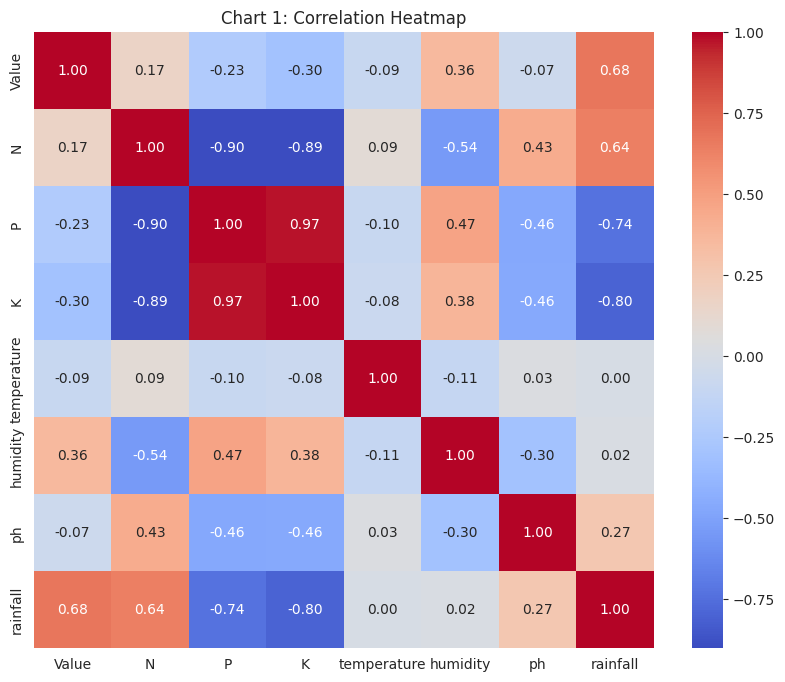

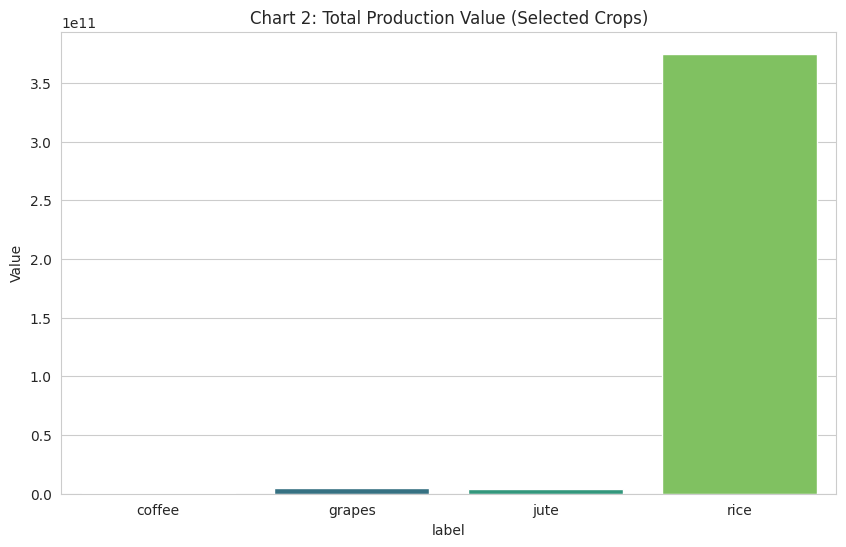

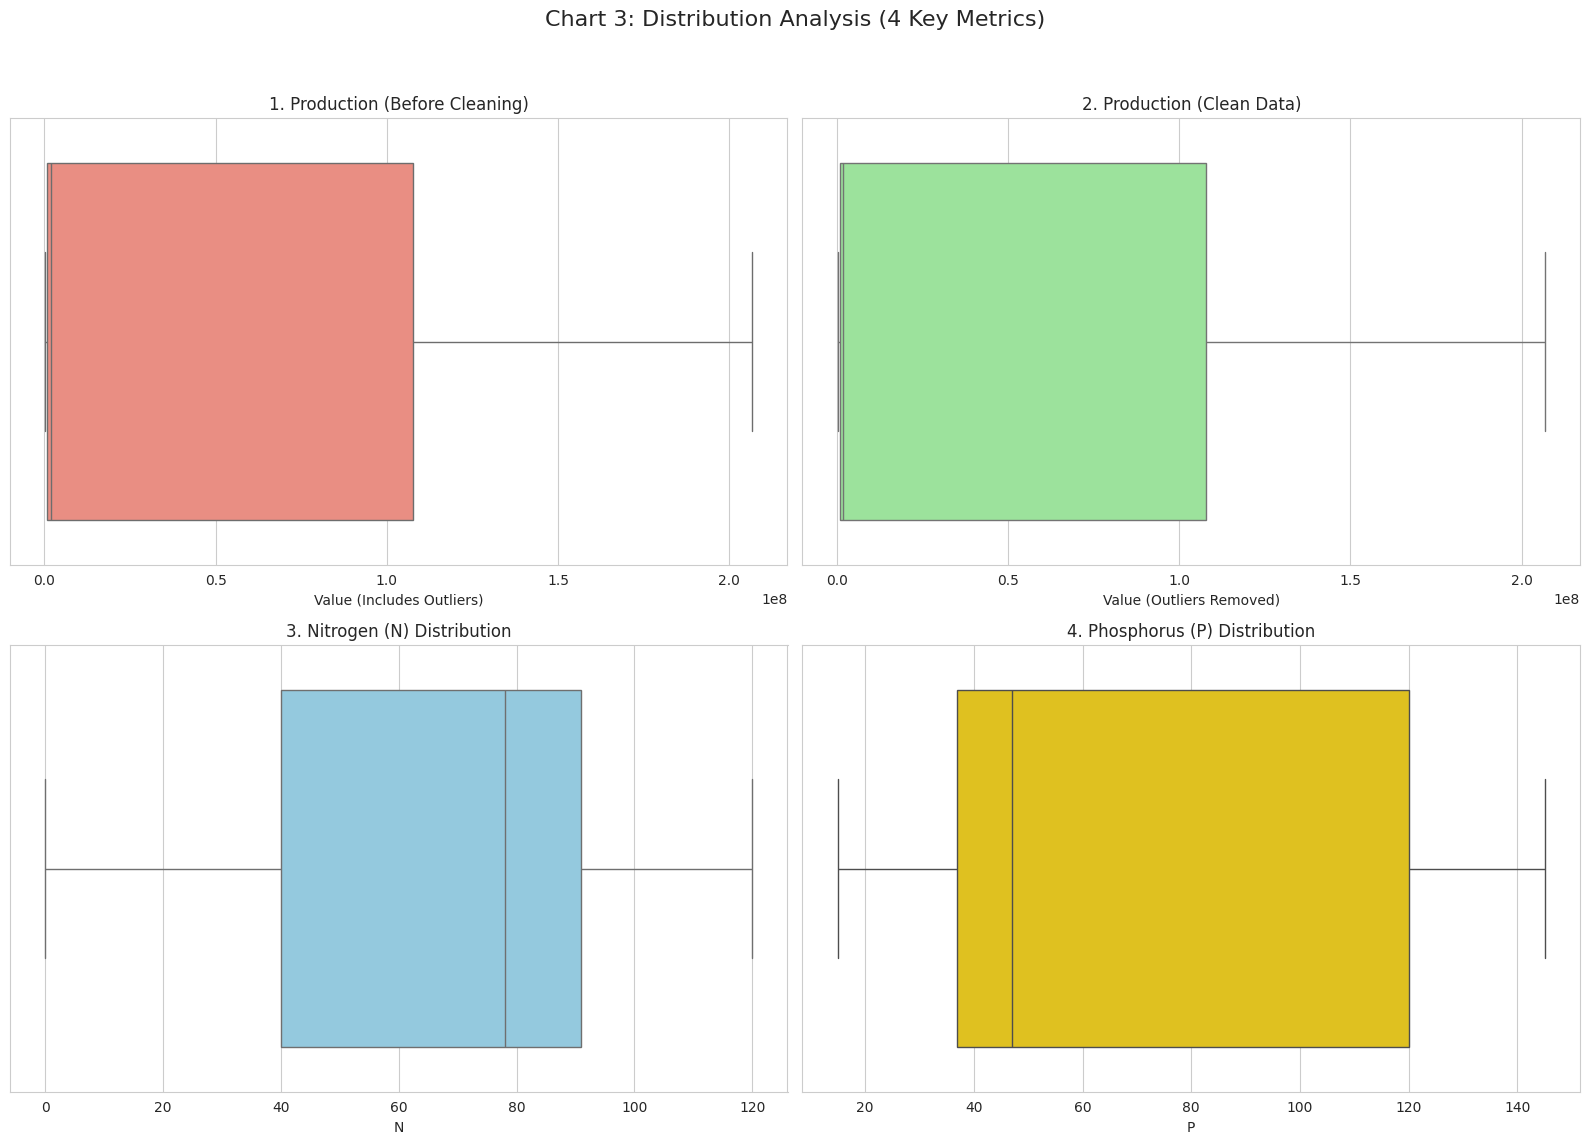

In [8]:
# Task 8: Complete EDA (Per-Crop Cleaning + 4 Specific Boxplots)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- PART 0: FILTER CROPS ---
target_crops = ['rice', 'grapes', 'jute', 'coffee']
final_df = final_df[final_df['label'].isin(target_crops)].copy()

# --- PART 1: CLEANING ---

# 1. Nulls (Print -> Drop -> Shape)
print("--- Step 1: Nulls ---")
print("Nulls:\n", final_df.isnull().sum())
final_df.dropna(inplace=True)
print("Shape AFTER dropping nulls:", final_df.shape)

# 2. Duplicates (Print -> Drop -> Shape)
print("\n--- Step 2: Duplicates ---")
print("Duplicates:", final_df.duplicated().sum())
final_df.drop_duplicates(inplace=True)
print("Shape AFTER dropping duplicates:", final_df.shape)

# 3. Remove Outliers (PER CROP)
# We group by 'label' so Rice is compared to Rice, and Grapes to Grapes
print("\n--- Step 3: Removing Outliers ---")
numeric_cols = ['Value', 'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

def remove_outliers_per_group(group):
    for col in numeric_cols:
        Q1 = group[col].quantile(0.25)
        Q3 = group[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        group = group[(group[col] >= lower_bound) & (group[col] <= upper_bound)]
    return group

final_df_clean = final_df.groupby('label', group_keys=False).apply(remove_outliers_per_group)

print("Shape AFTER removing outliers:", final_df_clean.shape)
print("Crops Remaining:", final_df_clean['label'].unique()) # Should be all 4

# --- PART 2: VISUALIZATIONS ---
sns.set_style("whitegrid")

# CHART 1: Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(final_df_clean[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Chart 1: Correlation Heatmap")
plt.show()

# CHART 2: Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='Value', hue='label', data=final_df_clean, estimator=sum, errorbar=None, palette="viridis", legend=False)
plt.title("Chart 2: Total Production Value (Selected Crops)")
plt.show()

# CHART 3: The 4 Boxplots (2x2 Grid)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Chart 3: Distribution Analysis (4 Key Metrics)', fontsize=16)
axes = axes.flatten()

# Plot 1: Production (Before)
sns.boxplot(x=final_df['Value'], ax=axes[0], color='salmon')
axes[0].set_title('1. Production (Before Cleaning)', fontsize=12)
axes[0].set_xlabel('Value (Includes Outliers)')

# Plot 2: Production (After)
sns.boxplot(x=final_df_clean['Value'], ax=axes[1], color='lightgreen')
axes[1].set_title('2. Production (Clean Data)', fontsize=12)
axes[1].set_xlabel('Value (Outliers Removed)')

# Plot 3: Nitrogen
sns.boxplot(x=final_df_clean['N'], ax=axes[2], color='skyblue')
axes[2].set_title('3. Nitrogen (N) Distribution', fontsize=12)

# Plot 4: Phosphorus
sns.boxplot(x=final_df_clean['P'], ax=axes[3], color='gold')
axes[3].set_title('4. Phosphorus (P) Distribution', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()